In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import tools
from tools.cbook import pickle2Obj, interp_z, compute_thetae
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

teclevs = list(300. + 5*np.arange(70))

bclevs = list(-0.4+ 0.02*np.arange(100))
pclevs = list(-15.0 + np.arange(31))

dclevs = list(-20.0 + np.arange(41))

zlevels = 25.0 + 50.*np.arange(300)

beta_dir = '/work/wicker/CAM_analysis_tools/ideal_cases/beta_diagnostic'

buoy_data = np.loadtxt("muCAPE.dat", skiprows=4, dtype=float) 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
paths = {}
paths['cm1_3km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_TESTA_hdd125_C2000_00'
#paths['cm1_2km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_test_hdd125_C2000_00'
#paths['cm1_1km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt01_hdd125_C2000_00'

cm1 = []

for key in paths:
    
    beta_file = os.path.join(beta_dir, "%s_%s_beta_out.nc" % ('cm1', os.path.basename(paths[key]) ))
    print("Reading: ",key, beta_file)
    cm1.append( read_cm1_fields(paths[key], vars = ['den','buoy'], ret_beta=beta_file, zinterp=zlevels) )
    paths = {}
    
# paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00'
# paths['solo2'] = '/work/wicker/Odin_scr/solo/bubble_3km_makenh_hdd125_C2000_00'
# paths['solo3'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt06_hdd125_C2000_00'
paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_TESTA_hdd125_C2000_00'

solo = []
for key in paths:
    beta_file = os.path.join(beta_dir, "%s_%s_beta_out.nc" % ('solo', os.path.basename(paths[key]) ))
    print("Reading: ",key, beta_file)
    solo.append( read_solo_fields(paths[key], vars = ['den','buoy'], ret_beta=beta_file, zinterp=zlevels) )



Reading:  cm1_3km_hdd125 /work/wicker/CAM_analysis_tools/ideal_cases/beta_diagnostic/cm1_bubble_3km_TESTA_hdd125_C2000_00_beta_out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_TESTA_hdd125_C2000_00/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_TESTA_hdd125_C2000_00/cm1out.nc 

 Reading BETA from /work/wicker/CAM_analysis_tools/ideal_cases/beta_diagnostic/cm1_bubble_3km_TESTA_hdd125_C2000_00_beta_out.nc
 Completed reading in:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_TESTA_hdd125_C2000_00/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
 Interpolating fields to single column z-grid:  /work/wick

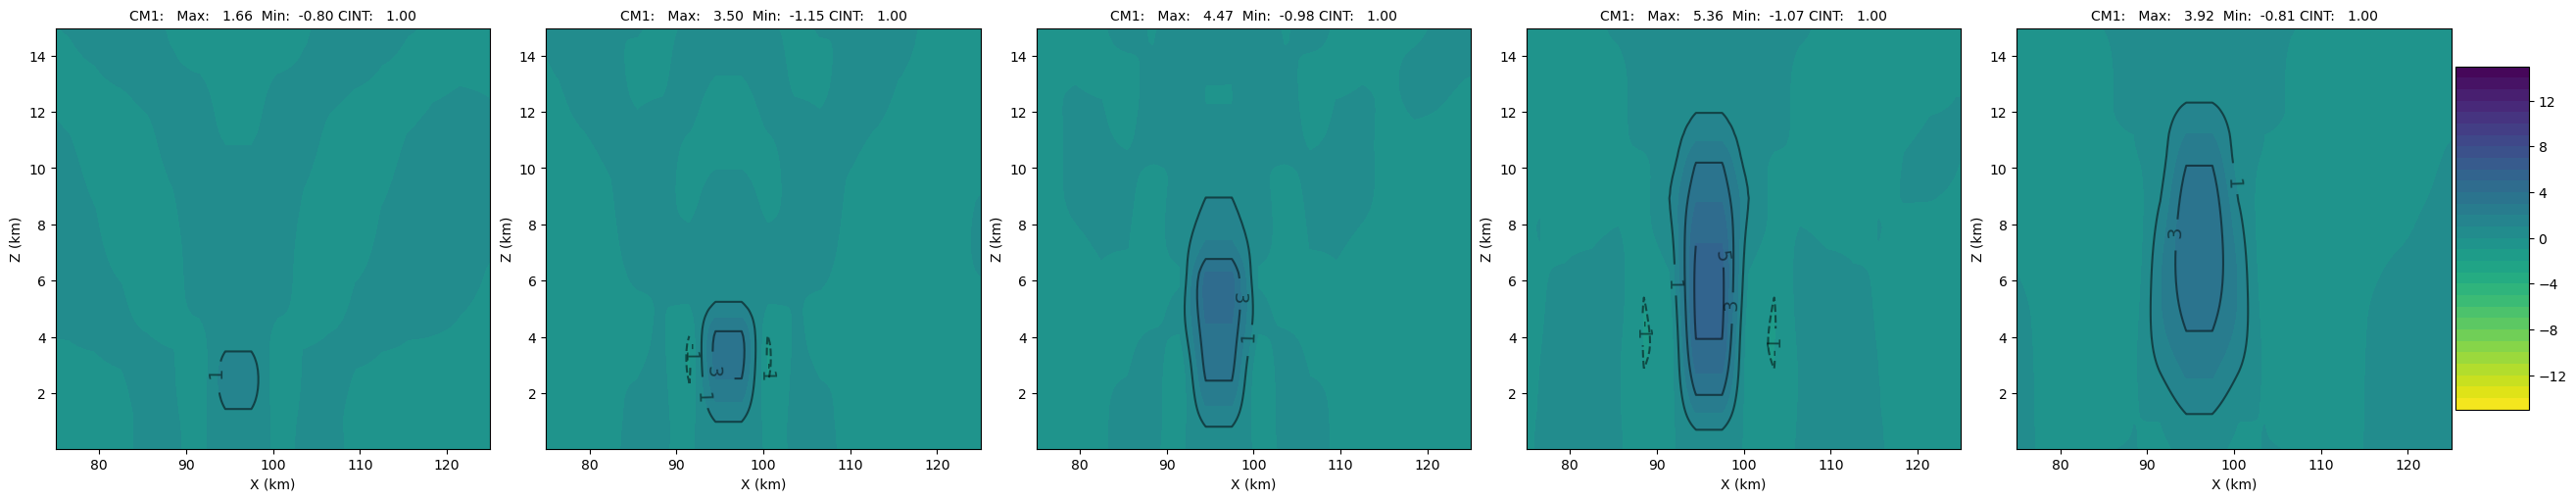

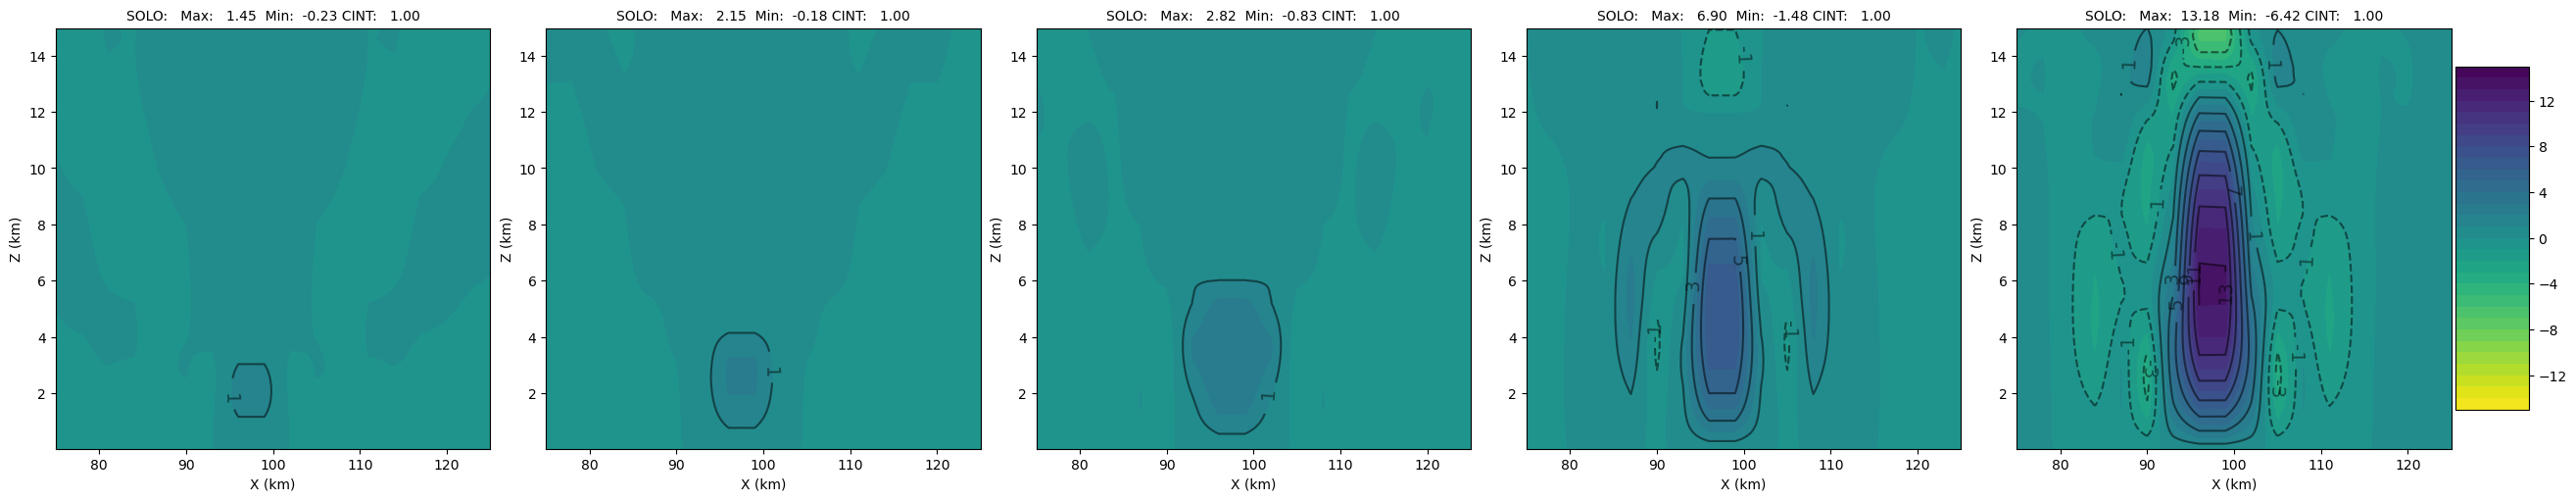

In [4]:
t0 = [10, 15, 20, 30, 40]

cm1_list  = []
solo_list = []

for tloc in t0:

    jloc = 31

    cm1_list.append( container( cm1[0]['xc'][:]*.001,  zlevels*.001,  100*cm1[0]['beta'][tloc+1,:,jloc, :]) )
    solo_list.append( container(solo[0]['xc'][:]*.001, zlevels*.001,  100*solo[0]['beta'][tloc,:,jloc, :]) )

plot_contour_row(cm1_list, levels=pclevs, title='CM1', xlabel='X (km)', ylabel='Z (km)', range=[75.,125.], cmap=plt.cm.viridis_r);
plot_contour_row(solo_list, levels=pclevs, title='SOLO', xlabel='X (km)', ylabel='Z (km)', range=[75.,125.],cmap=plt.cm.viridis_r);




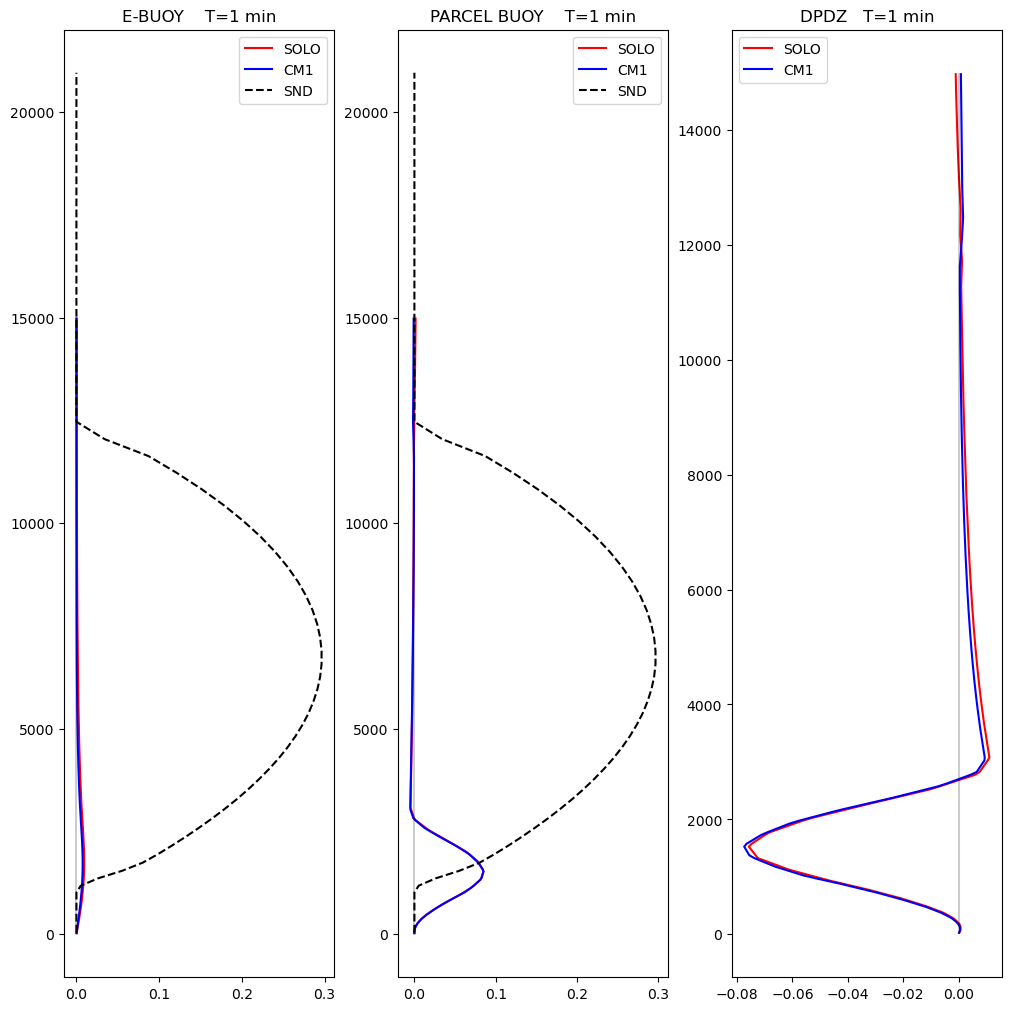

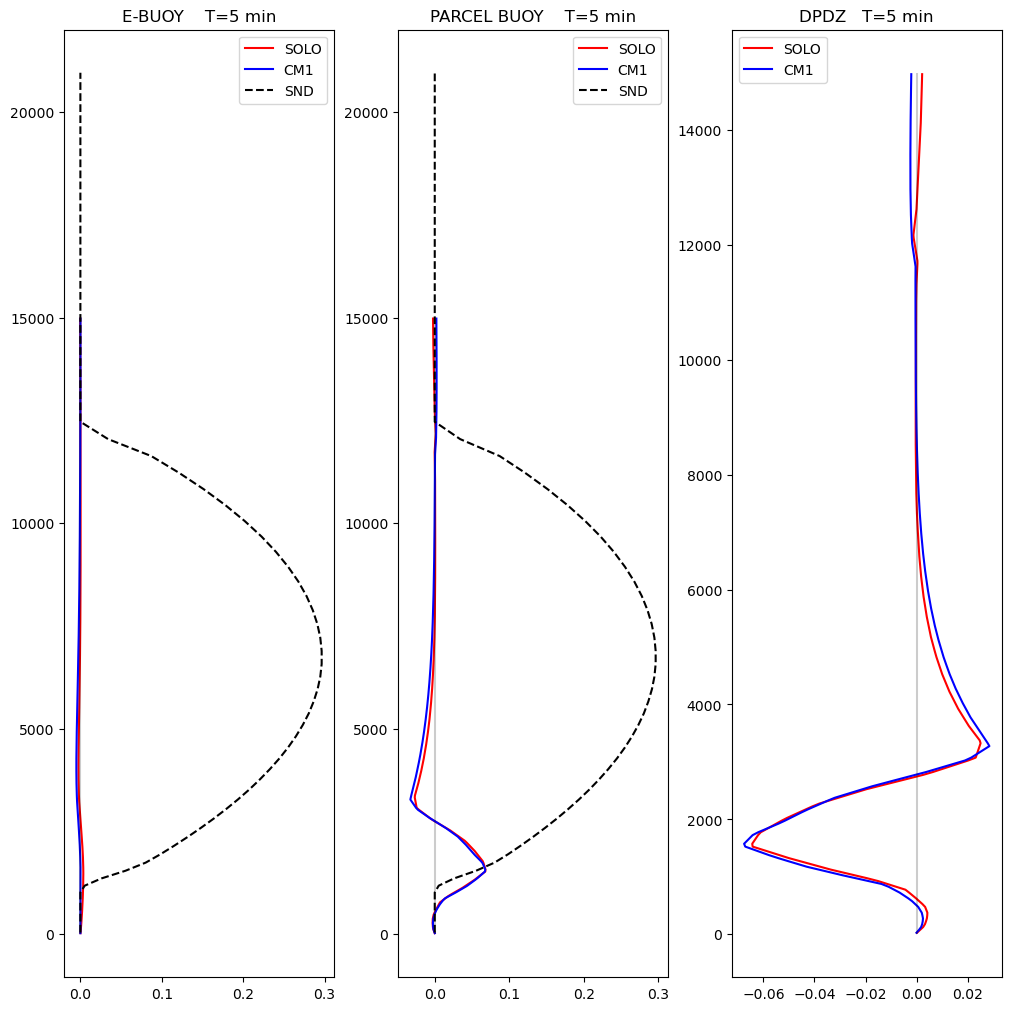

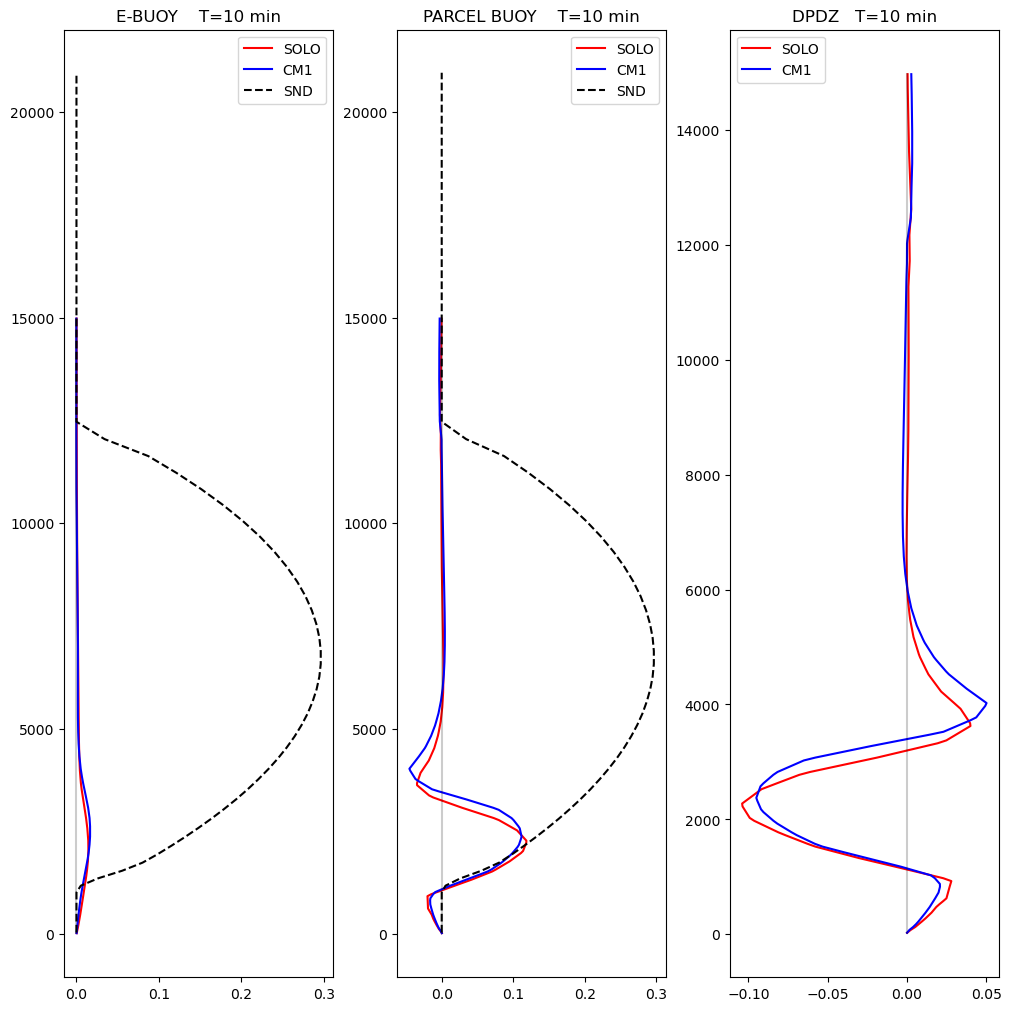

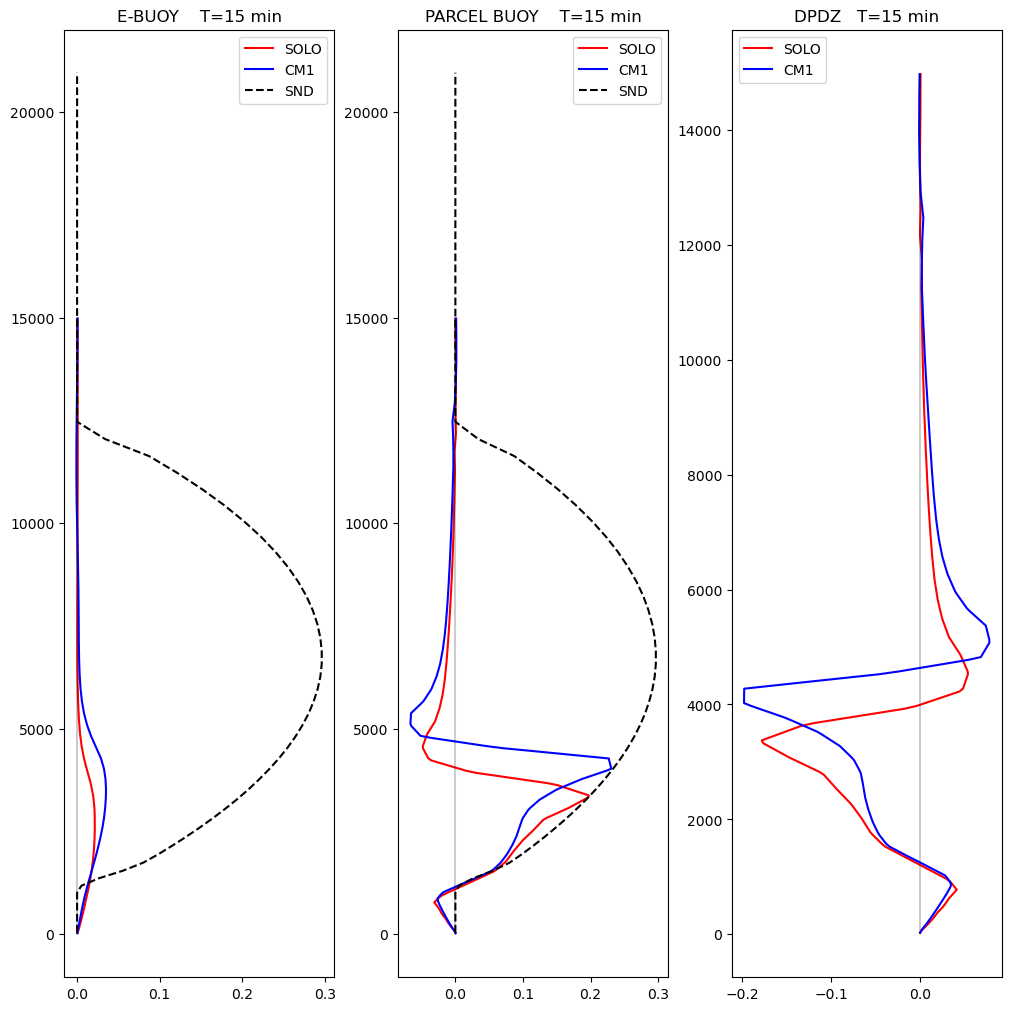

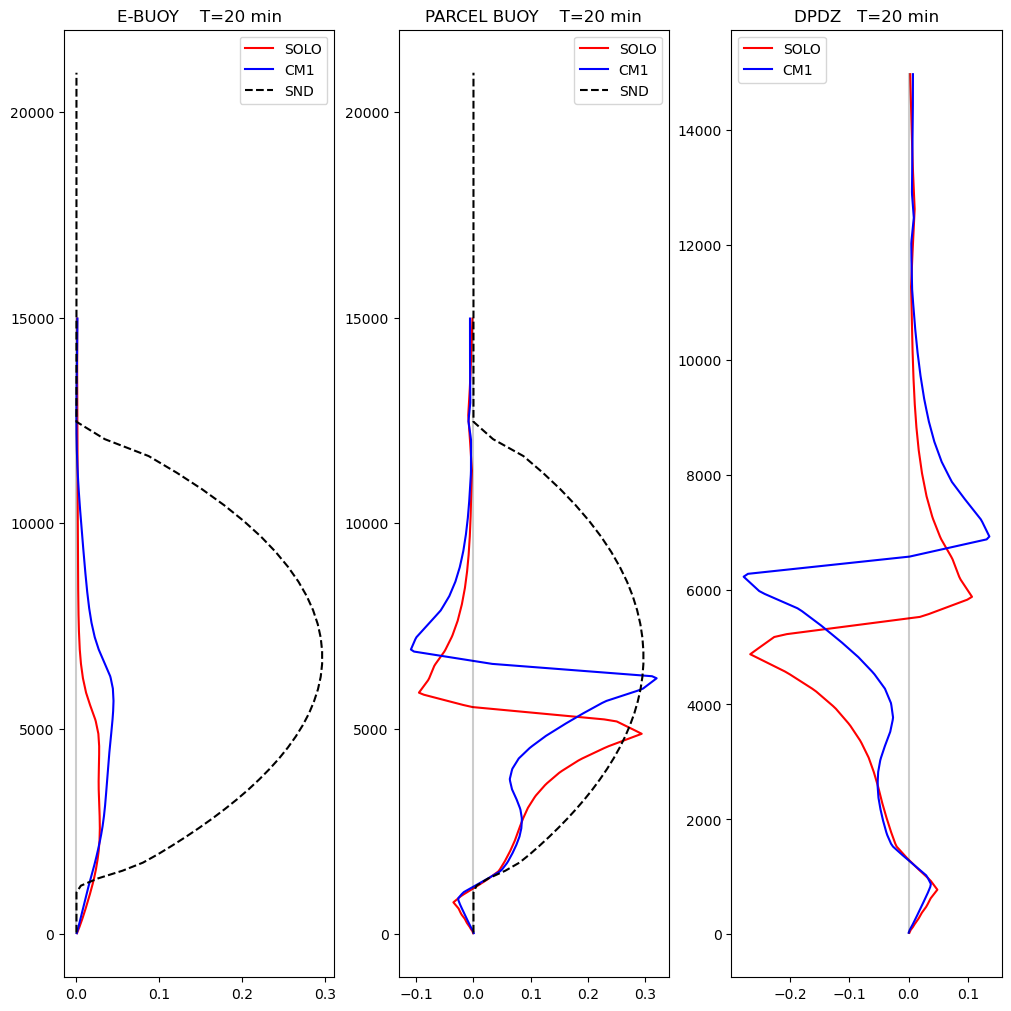

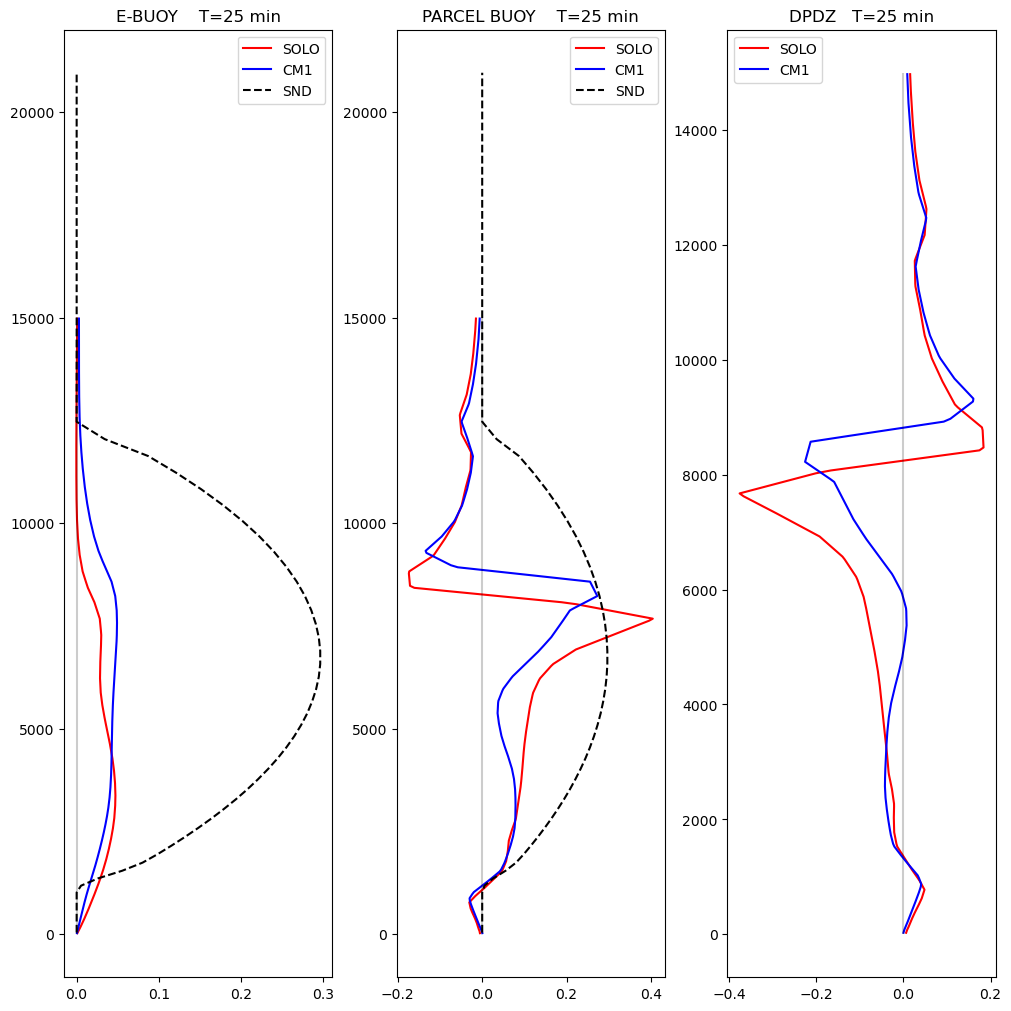

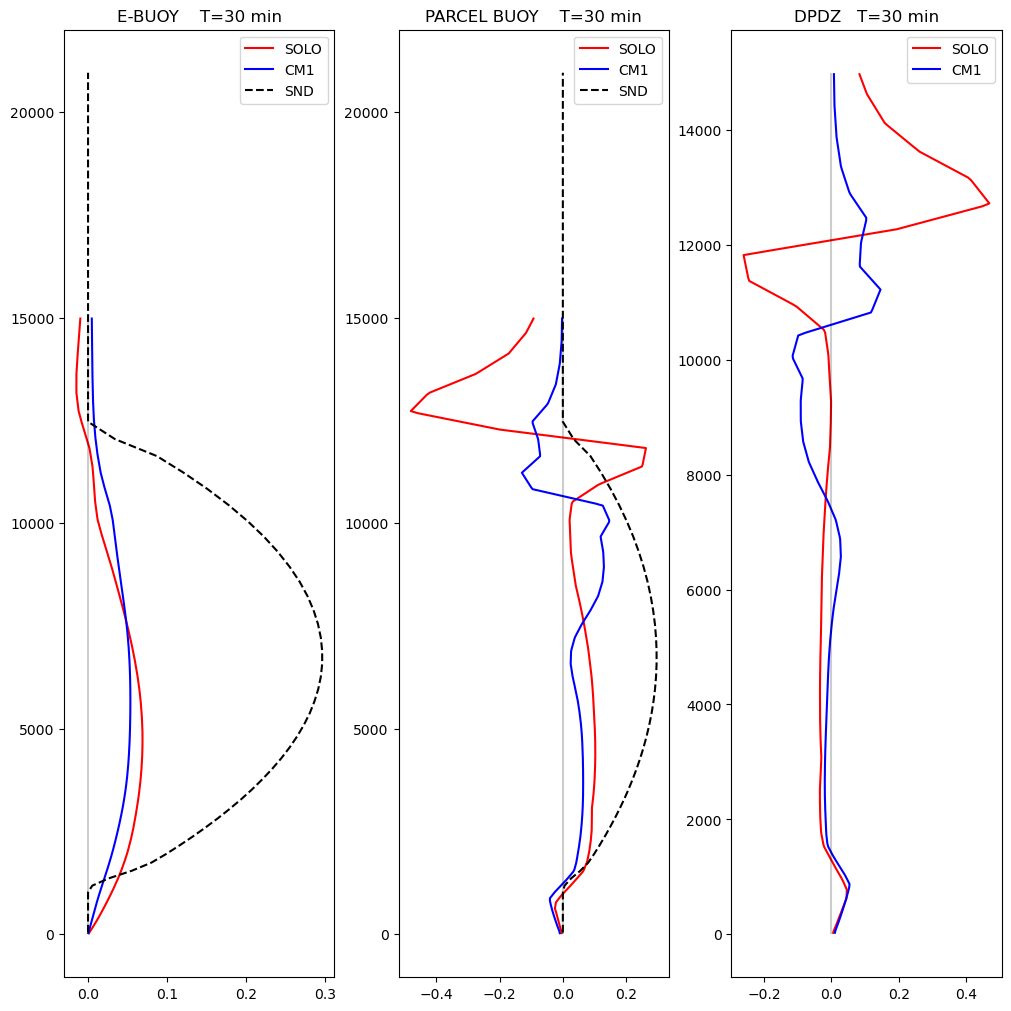

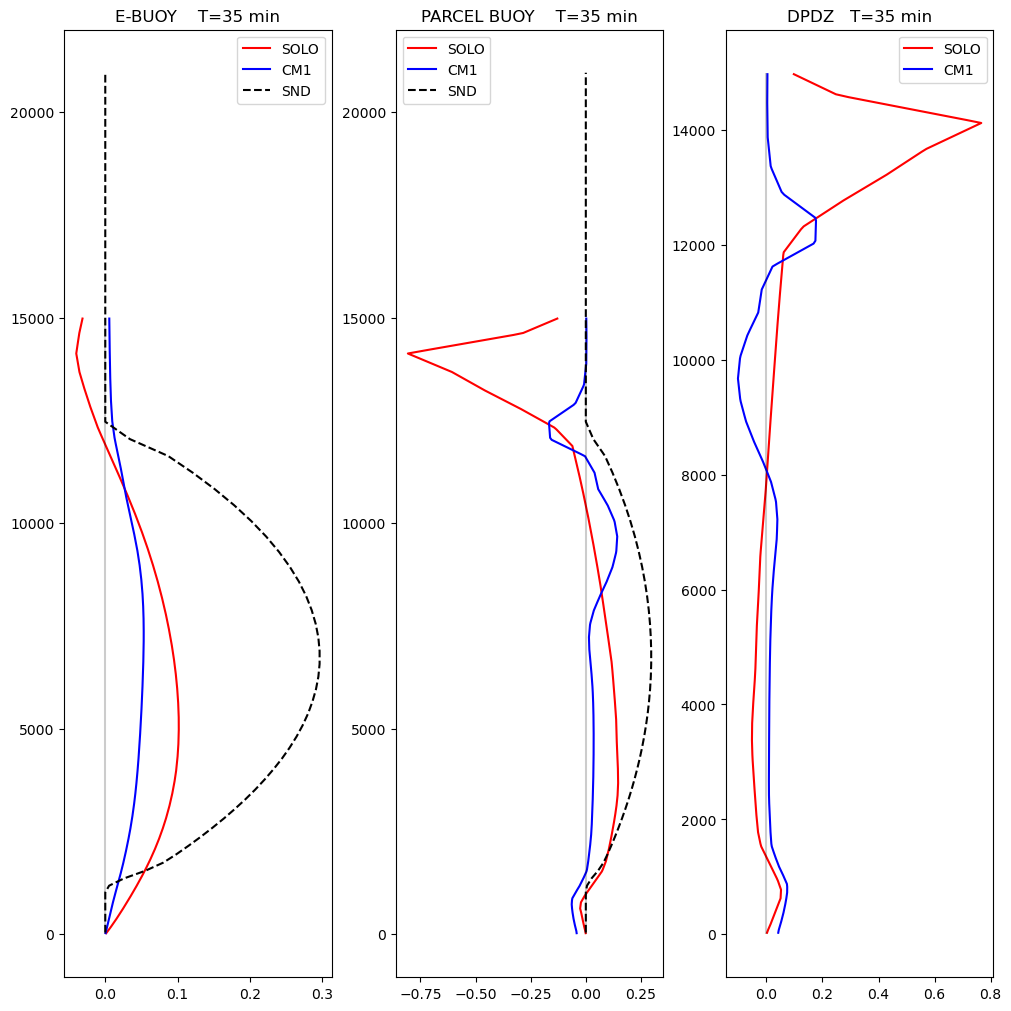

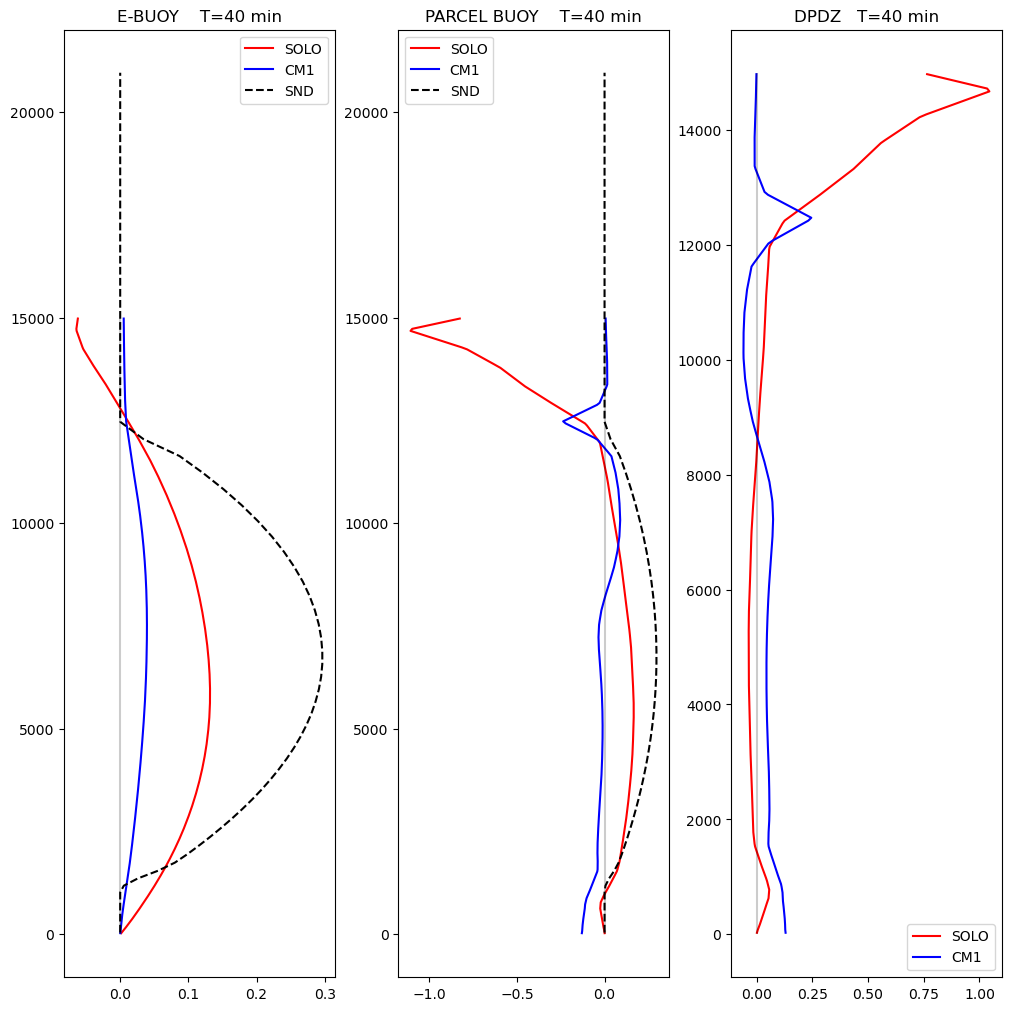

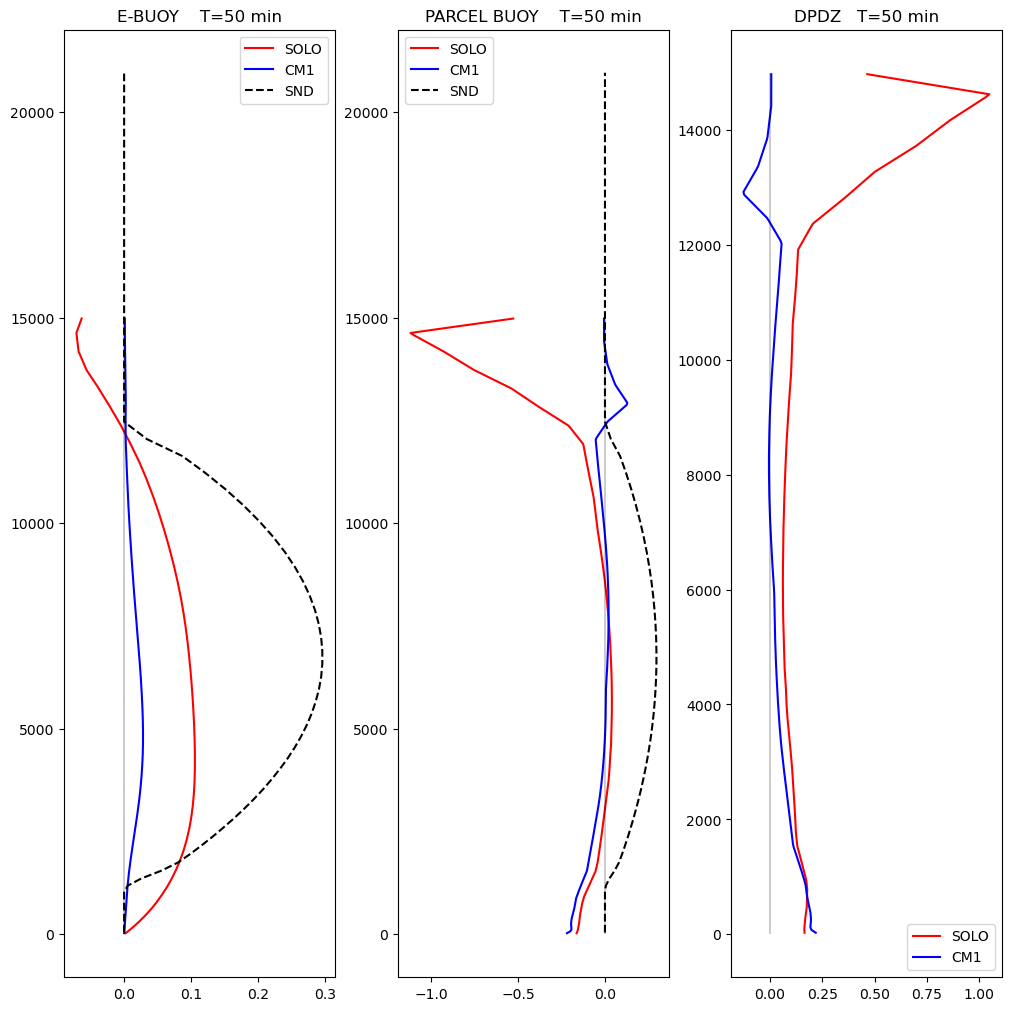

In [10]:
t0 = [1,5,10,15,20,25,30,35,40,50]


for tloc in t0:

    jloc = 31
    iloc = 31

    fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(10,10))

    ax[0].plot(solo[0]['beta'][tloc,:,jloc, iloc], zlevels, color='r', label='SOLO')
    ax[0].plot(cm1[0]['beta'][tloc+1,:,jloc, iloc], zlevels, color='b', label='CM1')
    ax[0].plot(buoy_data[:,2], buoy_data[:,0], color='k', linestyle='--', label='SND')
    ax[0].vlines(0.0, 0.0, 15000., color='k', alpha=0.2)
    ax[0].set_title('E-BUOY    T=%d min'%(tloc))

    ax[1].plot(solo[0]['buoy'][tloc,:,jloc, iloc], zlevels, color='r', label='SOLO')
    ax[1].plot(cm1[0]['buoy'][tloc+1,:,jloc, iloc], zlevels, color='b', label='CM1')
    ax[1].plot(buoy_data[:,2], buoy_data[:,0], color='k', linestyle='--', label='SND')
    ax[1].vlines(0.0, 0.0, 15000., color='k', alpha=0.2)
    ax[1].set_title('PARCEL BUOY    T=%d min'%(tloc))

    ax[2].plot(solo[0]['beta'][tloc,:,jloc, iloc] - solo[0]['buoy'][tloc,:,jloc, iloc], zlevels, color='r', label='SOLO')
    ax[2].plot(cm1[0]['beta'][tloc+1,:,jloc, iloc] - cm1[0]['buoy'][tloc+1,:,jloc, iloc], zlevels, color='b', label='CM1')
    # ax[1].plot(buoy_data[:,2], buoy_data[:,0], color='k', linestyle='--', label='SND')
    ax[2].vlines(0.0, 0.0, 15000., color='k', alpha=0.2)
    ax[2].set_title('DPDZ   T=%d min'%(tloc))


    for item in ax.flatten():
        item.legend();


In [ ]:
t0 = [1,5,10,15,20,25,30,35,40,50]


for tloc in t0:

    jloc = 31
    iloc = 31

    fig, ax = plt.subplots(1,2, constrained_layout=True,figsize=(10,10))

    ax[0].plot(solo[0]['beta'][tloc,:,jloc, iloc], zlevels, color='r', label='SOLO')
    ax[0].plot(cm1[0]['beta'][tloc+1,:,jloc, iloc], zlevels, color='b', label='CM1')
    ax[0].plot(buoy_data[:,2], buoy_data[:,0], color='k', linestyle='--', label='SND')
    ax[0].vlines(0.0, 0.0, 15000., color='k', alpha=0.2)
    ax[0].set_title('E-BUOY    T=%d min'%(tloc))

    ax[1].plot(solo[0]['buoy'][tloc,:,jloc, iloc], zlevels, color='r', label='SOLO')
    ax[1].plot(cm1[0]['buoy'][tloc+1,:,jloc, iloc], zlevels, color='b', label='CM1')
    ax[1].plot(buoy_data[:,2], buoy_data[:,0], color='k', linestyle='--', label='SND')
    ax[1].vlines(0.0, 0.0, 15000., color='k', alpha=0.2)
    ax[1].set_title('BUOY    T=%d min'%(tloc))

    for item in ax.flatten():
        item.legend();